In [1]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems
# test new laptop

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import timeit
import json 
import random
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager


In [2]:
font_dirs = ['Data\Source_Sans_Pro', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'Source Sans Pro'

In [3]:
day_profile =pd.read_json(open('Outputs/Logs/run10/profiles10.json',))
site_summary =pd.read_json(open('Outputs/Logs/run10/site_summary10.json',))

In [4]:
day_profile['Index'] = day_profile.index.values
day_profile['from'] = day_profile['Index'].str.split('\'').str[1]
day_profile['Route_ID'] = day_profile['Index'].str[-8:-1]
day_profile['from'] = day_profile['from'].astype('datetime64[ns]')
day_profile.drop(columns='Index',inplace=True)
day_profile.set_index(['from','Route_ID'],inplace=True)

In [5]:
site_summary.head()

,Electricity_Price,Output_Opt,Output_BAU,Output_BAU2,ChDelivered_Opt,ECost_Opt,SoC_Opt,ChDelivered_BAU,ECost_BAU,SoC_BAU,ChDelivered_BAU2,ECost_BAU2,SoC_BAU2,N_Opt,N_BAU,N_BAU2
2019-02-10 11:00:00,12.26,0.0,0.0,0.0,0.0,0.00,65.74901,0.0,0.00,65.74901,0.0,0.00,65.74901,0,0,0
2019-02-10 11:30:00,12.02,0.0,0.0,0.0,0.0,0.00,65.74901,0.0,0.00,65.74901,0.0,0.00,65.74901,0,0,0
2019-02-10 12:00:00,11.60,0.0,22.0,22.0,0.0,0.00,65.74901,19.8,255.20,66.57401,19.8,255.20,66.57401,0,2,2
2019-02-10 12:30:00,11.36,0.0,22.0,22.0,0.0,0.00,65.74901,19.8,249.92,67.39901,19.8,249.92,67.39901,0,2,2
2019-02-10 13:00:00,8.96,22.0,22.0,22.0,19.8,197.12,66.57401,19.8,197.12,68.22401,19.8,197.12,68.22401,2,2,2


In [6]:
site_summary['Index'] = site_summary.index.values
site_summary['from'] = site_summary['Index'].astype('datetime64[ns]')
site_summary.drop(columns='Index',inplace=True)
site_summary.set_index(['from'],inplace=True)
site_summary.head()

,Electricity_Price,Output_Opt,Output_BAU,Output_BAU2,ChDelivered_Opt,ECost_Opt,SoC_Opt,ChDelivered_BAU,ECost_BAU,SoC_BAU,ChDelivered_BAU2,ECost_BAU2,SoC_BAU2,N_Opt,N_BAU,N_BAU2
from,,,,,,,,,,,,,,,,
2019-02-10 11:00:00,12.26,0.0,0.0,0.0,0.0,0.00,65.74901,0.0,0.00,65.74901,0.0,0.00,65.74901,0,0,0
2019-02-10 11:30:00,12.02,0.0,0.0,0.0,0.0,0.00,65.74901,0.0,0.00,65.74901,0.0,0.00,65.74901,0,0,0
2019-02-10 12:00:00,11.60,0.0,22.0,22.0,0.0,0.00,65.74901,19.8,255.20,66.57401,19.8,255.20,66.57401,0,2,2
2019-02-10 12:30:00,11.36,0.0,22.0,22.0,0.0,0.00,65.74901,19.8,249.92,67.39901,19.8,249.92,67.39901,0,2,2
2019-02-10 13:00:00,8.96,22.0,22.0,22.0,19.8,197.12,66.57401,19.8,197.12,68.22401,19.8,197.12,68.22401,2,2,2


In [7]:
day_profile.head()

Electricity_Price  Time_Price  Vehicle_ID  \
from                Route_ID                                              
2019-02-10 11:00:00 2104108               12.26         502           3   
                    2104116               12.26         502           4   
                    2104120               12.26         502          12   
                    2104123               12.26         502           3   
                    2104125               12.26         502           4   

                              Output_Opt  Output_BAU  Output_BAU2  \
from                Route_ID                                        
2019-02-10 11:00:00 2104108          0.0         0.0          0.0   
                    2104116          0.0         0.0          0.0   
                    2104120          0.0         0.0          0.0   
                    2104123          0.0         0.0          0.0   
                    2104125          0.0         0.0          0.0   

                              ChDelivered_Opt  ECost_Opt    SoC_Opt  \
from                Route_ID                                          
2019-02-10 11:00:00 2104108               0.0        0.0  64.571644   
                    2104116               0.0        0.0  68.573778   
                    2104120               0.0        0.0  64.938542   
                    2104123               0.0        0.0  63.152276   
                    2104125               0.0        0.0  59.365991   

                              ChDelivered_BAU  ECost_BAU    SoC_BAU  \
from                Route_ID                                          
2019-02-10 11:00:00 2104108               0.0        0.0  64.571644   
                    2104116               0.0        0.0  68.573778   
                    2104120               0.0        0.0  64.938542   
                    2104123               0.0        0.0  63.152276   
                    2104125               0.0        0.0  59.365991   

                              ChDelivered_BAU2  ECost_BAU2   SoC_BAU2  
from                Route_ID                                           
2019-02-10 11:00:00 2104108                0.0         0.0  64.571644  
                    2104116                0.0         0.0  68.573778  
                    2104120                0.0         0.0  64.938542  
                    2104123                0.0         0.0  63.152276  
                    2104125                0.0         0.0  59.365991

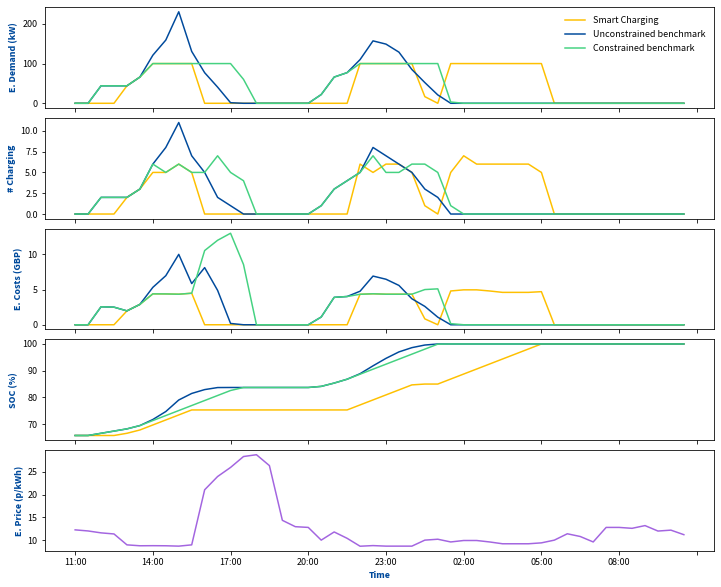

In [8]:
run = 20
fig = f.summary_plot(site_summary)



fig.savefig('Outputs/Logs/run{}/fig2{}.jpg'.format(run,run),facecolog='white')